# import

In [1]:
import os
import time
import math
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KernelDensity
from scipy.stats import kstest, gaussian_kde, ks_2samp, chi2_contingency, wasserstein_distance, norm
from scipy.interpolate import interp1d
from sdv.metadata import MultiTableMetadata
from sdv.evaluation.single_table import evaluate_quality as st_evaluate_quality
from sdv.evaluation.single_table import run_diagnostic as st_run_diagnostic
from sdv.evaluation.multi_table import evaluate_quality as mt_evaluate_quality
from sdv.evaluation.multi_table import run_diagnostic as mt_run_diagnostic

In [2]:
set_verbosity(ERROR)

# load data

In [3]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [4]:
real_data_collection = load_data_collection("gtfs")

In [5]:
del real_data_collection['shapes']

## Create Metadata

In [6]:
def auto_detect_relation(data_collection):
    metadata = {}
    for df_name, df in data_collection.items():
        parent = {}
        child = []
        primary_key = []
        foreign_key = []
        for col in df.columns:
            if 'id' in col:
                if df[col].nunique() == len(df):
                    primary_key = [col, len(df)]
                else:
                    foreign_key.append(col)
        for foreign_df_name, foreign_df in data_collection.items():
            if foreign_df_name != df_name:
                for fr_col in foreign_df.columns:
                    if 'id' in fr_col:
                        for fr_k in foreign_key:
                            if fr_col == fr_k and foreign_df[fr_col].nunique() == len(foreign_df):
                                parent[foreign_df_name] = fr_k
                        if primary_key != []:
                            if fr_col == primary_key[0] and foreign_df[fr_col].nunique() != len(foreign_df):
                                child.append(foreign_df_name)
        metadata[df_name] = {'primary_key':primary_key,
                             'parent':parent,
                             'child':child,
                             'is_sequential':False,
                            'additional_key':None}
    return metadata

In [7]:
metadata = auto_detect_relation(real_data_collection)
metadata['calendar_dates']['is_sequential'] = True
metadata['stop_times']['is_sequential'] = True
metadata['calendar_dates']['additional_key'] = ['date']
metadata['stop_times']['additional_key'] = ['stop_sequence']
metadata['calendar_dates']['sort_order'] = ['service_id','date']
metadata['stop_times']['sort_order'] = ['trip_id','stop_sequence']

In [8]:
metadata

{'agency': {'primary_key': ['agency_id', 15],
  'parent': {},
  'child': ['routes'],
  'is_sequential': False,
  'additional_key': None},
 'calendar': {'primary_key': ['service_id', 121],
  'parent': {},
  'child': ['calendar_dates', 'trips'],
  'is_sequential': False,
  'additional_key': None},
 'calendar_dates': {'primary_key': [],
  'parent': {'calendar': 'service_id'},
  'child': [],
  'is_sequential': True,
  'additional_key': ['date'],
  'sort_order': ['service_id', 'date']},
 'routes': {'primary_key': ['route_id', 215],
  'parent': {'agency': 'agency_id'},
  'child': ['trips'],
  'is_sequential': False,
  'additional_key': None},
 'stops': {'primary_key': ['stop_id', 6714],
  'parent': {},
  'child': ['stop_times'],
  'is_sequential': False,
  'additional_key': None},
 'stop_times': {'primary_key': [],
  'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
  'child': [],
  'is_sequential': True,
  'additional_key': ['stop_sequence'],
  'sort_order': ['trip_id', 'stop_sequence']},

# preprocess

## Create Factorization Dictionary:

In [9]:
def create_factorization_dict(data_collection, metadata):
    factor_dict = {}
    for df_name, df in data_collection.items():
        local_id_dict = {}
        primary_key_info = metadata[df_name]['primary_key']
        if primary_key_info != []:
            local_id_dict = {k:v for v,k in enumerate(df[primary_key_info[0]].unique())}
            factor_dict[primary_key_info[0]] = local_id_dict
    return factor_dict

In [10]:
factorization_dict = create_factorization_dict(real_data_collection, metadata)

## Format Individual Table:

In [11]:
def individual_preprocess_dict():
    preprocess_dict = {}
    preprocess_dict['transformation'] = {}
    preprocess_dict['transformation']['drop'] = []
    preprocess_dict['transformation']['factorize'] = []
    preprocess_dict['transformation']['to_strip'] = []
    preprocess_dict['transformation']['to_elapsed_time'] = []
    preprocess_dict['transformation']['to_elapsed_days'] = []
    preprocess_dict['nans_conversion'] = {}
    preprocess_dict['nans_conversion']['impute'] = []
    preprocess_dict['nans_conversion']['replace_with_neg_one'] = []
    preprocess_dict['nans_conversion']['replace_with_zeros'] = []
    return preprocess_dict

In [12]:
def format_individual_data(data, preprocess_dict, factorization_dict, timestamp = pd.Timestamp('1900-01-01')):
    # reverse_transform_dict = {}
    for stage in preprocess_dict.keys():
        if stage == 'transformation':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'drop':
                        data = data.drop(col_list, axis=1)
                    if method == 'factorize':
                        for col in col_list:
                            if col in factorization_dict.keys():
                                data[col] = data[col].map(factorization_dict[col])
                            else:
                                data[col] = pd.factorize(data[col], sort=True)[0]
                    if method == 'to_strip':
                        for col in col_list:
                            # convert some column to numbers
                            # e.g. `123-45-6` -> `123456`
                            data[col] = data[col].str.replace(r'\D', '').astype(int)
                    if method == "to_elapsed_time":
                        for col in col_list:
                            cur_col = pd.to_timedelta(data[col])
                            cur_col = cur_col % pd.Timedelta(days=1)
                            data[col] = cur_col.dt.total_seconds()
                    if method == "to_elapsed_days":
                        for col in col_list:
                            cur_col = pd.to_datetime(data[col], format='%Y%m%d') - timestamp
                            data[col] = cur_col.dt.days
        if stage == 'nans_conversion':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'impute':
                        imputer = SimpleImputer(strategy='mean')
                        data[col_list] = imputer.fit_transform(data[col_list])
                    if method == 'replace_with_neg_one':
                        data[col_list] = data[col_list].fillna(-1)
                    if method == 'replace_with_zeros':
                        data[col_list] = data[col_list].fillna(0)
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaled_data = scaler.fit_transform(data)
    return data

## preprocess individual data

In [13]:
sdv_metadata = MultiTableMetadata()

In [14]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['agency_name','agency_fare_url','agency_email']
preprocess_dict['transformation']['factorize'] = ['agency_id','agency_url','agency_timezone','agency_lang','agency_phone']
real_data_collection['agency'] = format_individual_data(real_data_collection['agency'], preprocess_dict, factorization_dict)

In [15]:
sdv_metadata.detect_table_from_dataframe(table_name='agency', data=real_data_collection['agency'])
sdv_metadata.update_column(table_name='agency',column_name='agency_id',sdtype='id')
sdv_metadata.update_column(table_name='agency',column_name='agency_url',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_timezone',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_lang',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_phone',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='agency',column_name='agency_id')

### calendar

In [16]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
real_data_collection['calendar'] = format_individual_data(real_data_collection['calendar'], preprocess_dict, factorization_dict)

In [17]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar',data=real_data_collection['calendar'])
sdv_metadata.update_column(table_name='calendar',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='calendar',column_name='monday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='tuesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='wednesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='thursday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='friday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='saturday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='sunday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='start_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='calendar',column_name='end_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.set_primary_key(table_name='calendar',column_name='service_id')

### calendar_dates

In [18]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['date']
real_data_collection['calendar_dates'] = format_individual_data(real_data_collection['calendar_dates'], preprocess_dict, factorization_dict)

In [19]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar_dates',data=real_data_collection['calendar_dates'])
sdv_metadata.update_column(table_name='calendar_dates',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='calendar_dates',column_name='date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='calendar_dates',column_name='exception_type',sdtype='categorical')

### routes

In [20]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['route_short_name','route_long_name','route_desc','route_url','route_sort_order']
preprocess_dict['transformation']['factorize'] = ['route_id',
                                                  'agency_id',
                                                 'route_color',
                                                 'route_text_color',
                                                 'contract_id']
preprocess_dict['nans_conversion']['impute'] = ['route_color','route_text_color']
real_data_collection['routes'] = format_individual_data(real_data_collection['routes'], preprocess_dict, factorization_dict)

In [21]:
real_data_collection['routes']['route_color'] = real_data_collection['routes']['route_color'].astype(int)
real_data_collection['routes']['route_text_color'] = real_data_collection['routes']['route_text_color'].astype(int)

In [22]:
sdv_metadata.detect_table_from_dataframe(table_name='routes',data=real_data_collection['routes'])
sdv_metadata.update_column(table_name='routes',column_name='route_id',sdtype='id')
sdv_metadata.update_column(table_name='routes',column_name='agency_id',sdtype='id')
sdv_metadata.update_column(table_name='routes',column_name='route_type',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_text_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='contract_id',sdtype='id')
sdv_metadata.set_primary_key(table_name='routes',column_name='route_id')

### stops

In [23]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['stop_id','parent_station','platform_code']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
preprocess_dict['transformation']['drop'] = ['stop_name','stop_code','stop_desc','zone_id','stop_url','stop_timezone']
preprocess_dict['nans_conversion']['impute'] = ['parent_station','platform_code']
real_data_collection['stops'] = format_individual_data(real_data_collection['stops'], preprocess_dict, factorization_dict)

In [24]:
real_data_collection['stops']['parent_station'] = real_data_collection['stops']['parent_station'].astype(int)
real_data_collection['stops']['platform_code'] = real_data_collection['stops']['platform_code'].astype(int)

In [25]:
sdv_metadata.detect_table_from_dataframe(table_name='stops',data=real_data_collection['stops'])
sdv_metadata.update_column(table_name='stops',column_name='stop_id',sdtype='id')
sdv_metadata.update_column(table_name='stops',column_name='stop_lat',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='stop_lon',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='location_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='parent_station',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='platform_code',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='wheelchair_boarding',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='start_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stops',column_name='end_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.set_primary_key(table_name='stops',column_name='stop_id')

### stop_times

In [26]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['trip_id','stop_id','stop_headsign']
preprocess_dict['transformation']['to_elapsed_time'] = ['arrival_time','departure_time']
real_data_collection['stop_times'] = format_individual_data(real_data_collection['stop_times'], preprocess_dict, factorization_dict)

In [27]:
real_data_collection['stop_times']['arrival_time'] = real_data_collection['stop_times']['arrival_time'].astype(int)
real_data_collection['stop_times']['departure_time'] = real_data_collection['stop_times']['departure_time'].astype(int)

In [28]:
sdv_metadata.detect_table_from_dataframe(table_name='stop_times',data=real_data_collection['stop_times'])
sdv_metadata.update_column(table_name='stop_times',column_name='trip_id',sdtype='id')
sdv_metadata.update_column(table_name='stop_times',column_name='arrival_time',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='departure_time',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_id',sdtype='id')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_sequence',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='pickup_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='drop_off_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='shape_dist_traveled',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stop_times',column_name='timepoint',sdtype='categorical')

### trips

In [29]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['route_id','service_id','trip_id','trip_headsign','shape_id']
preprocess_dict['transformation']['drop'] = ['trip_short_name','block_id']
real_data_collection['trips'] = format_individual_data(real_data_collection['trips'], preprocess_dict, factorization_dict)

In [30]:
sdv_metadata.detect_table_from_dataframe(table_name='trips',data=real_data_collection['trips'])
sdv_metadata.update_column(table_name='trips',column_name='route_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='trip_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='trip_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='direction_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='shape_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='wheelchair_accessible',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='bikes_allowed',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='trips',column_name='trip_id')

## Add SDV Relations

In [31]:
sdv_metadata.add_relationship(
    parent_table_name='agency',
    child_table_name='routes',
    parent_primary_key='agency_id',
    child_foreign_key='agency_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='calendar_dates',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='trips',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='routes',
    child_table_name='trips',
    parent_primary_key='route_id',
    child_foreign_key='route_id'
)

sdv_metadata.add_relationship(
    parent_table_name='stops',
    child_table_name='stop_times',
    parent_primary_key='stop_id',
    child_foreign_key='stop_id'
)

sdv_metadata.add_relationship(
    parent_table_name='trips',
    child_table_name='stop_times',
    parent_primary_key='trip_id',
    child_foreign_key='trip_id'
)

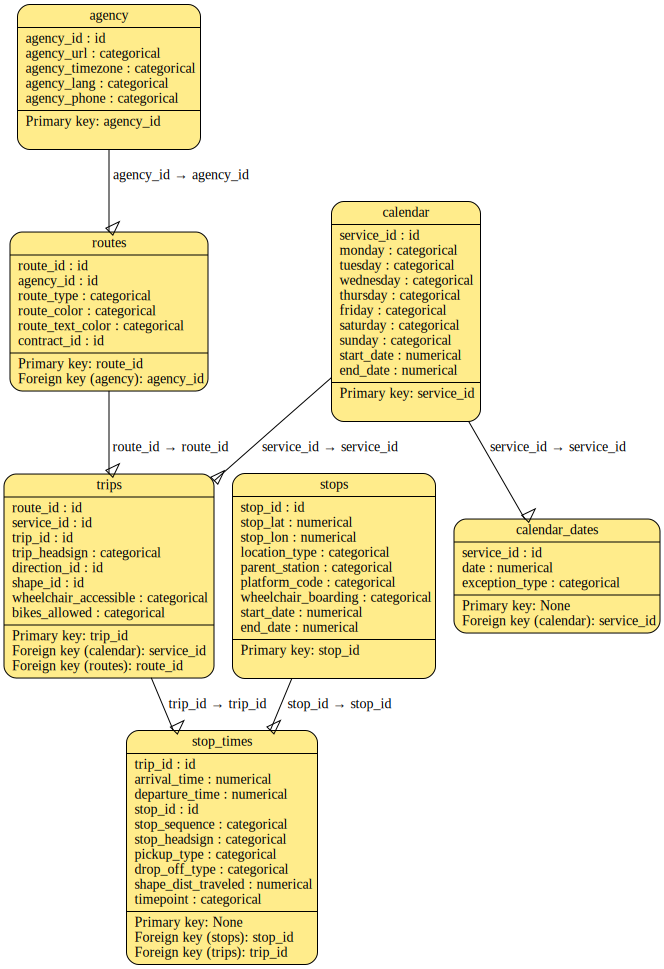

In [32]:
sdv_metadata.visualize()

## Obtain Foreign Key Distribution

In [33]:
# def get_distribution(array):
#     unique_elements, counts = np.unique(array, return_counts=True)
#     prob_distribution = counts / counts.sum()
#     return unique_elements, prob_distribution

In [34]:
# def get_cdf(array):
#     cdf = KernelDensity(kernel='gaussian', bandwidth=0.5)
#     cdf.fit(array.reshape(-1, 1))
#     unique_elements = np.unique(array)
#     return cdf, unique_elements

In [35]:
def get_cdf(array):
    mean, std = np.mean(array), np.std(array)
    cdf = norm(loc=mean, scale=std).cdf
    unique_elements = np.unique(array)
    return cdf, unique_elements

In [36]:
def add_key_cdf(data_collection, metadata):
    for df_name, content in metadata.items():
        key_cdf = {}
        if content['parent'] != {}:
            for parent_df_name, fr_k in content['parent'].items():
                cdf, unique_elements = get_cdf(data_collection[parent_df_name][fr_k].values)
                key_cdf[fr_k] = {'cdf':cdf, 'unique_elements':unique_elements}
        if content['is_sequential'] == True:
            for additional_key in content['additional_key']:
                cdf, unique_elements = get_cdf(data_collection[df_name][additional_key].values)
                key_cdf[additional_key] = {'cdf':cdf, 'unique_elements':unique_elements}
        metadata[df_name]['key_distribution'] = key_cdf

In [37]:
add_key_cdf(real_data_collection, metadata)

## Scaling

In [38]:
def scale_individual_df(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [39]:
def extract_key_and_scaled_features(df, label_columns):
    labels = df[label_columns]
    table = df.drop(columns=label_columns)
    table_column_names = table.columns
    scaled_table, table_scaler = scale_individual_df(table)
    scaled_labels, labels_scaler = scale_individual_df(labels)
    return scaled_table, scaled_labels, table_scaler, labels_scaler, table_column_names

In [40]:
def batch_scaling(data_collection, metadata):
    processed_data_collection = {}
    backtransformation_dict = {}
    for df_name, df in data_collection.items():
        primary_key = []
        foreign_key = []
        if metadata[df_name]['primary_key'] != []:
            primary_key = [metadata[df_name]['primary_key'][0]]
        if metadata[df_name]['parent'] != {}:
            foreign_key = list(metadata[df_name]['parent'].values())
        if metadata[df_name]['is_sequential'] == True:
            additional_key = list(metadata[df_name]['additional_key'])
            label_columns = primary_key + foreign_key + additional_key
        else:
            label_columns = primary_key + foreign_key
        table, labels, table_scaler, labels_scaler, table_columns = extract_key_and_scaled_features(df, label_columns)
        processed_data_collection[df_name] = {'table':table,
                                              'labels':labels}
        backtransformation_dict[df_name] = {'table_scaler':table_scaler,
                                       'labels_scaler':labels_scaler,
                                       'table_col_names':table_columns,
                                       'labels_col_names':label_columns,
                                       'col_names':df.columns}
    return processed_data_collection, backtransformation_dict

In [41]:
processed_data_collection, backtransformation_dict = batch_scaling(real_data_collection, metadata)

# Main GAN Algorithm

## Additional Custom Function (Wasserstein Loss) (\*Scrapped\*)

In [42]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

In [43]:
class ClipConstraint(constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

## Define Plotting Function For G/D Loss

In [44]:
import matplotlib.pyplot as plt

def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, (model_name, generator_log, critic_log) in enumerate(logs):
        axes[i].plot(generator_log, label='gen')
        axes[i].plot(critic_log, label='d')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

## (!) Define Main Generator, critic

In [45]:
def build_generator(table_dim, labels_dim, latent_dim=50):
    noise_input = layers.Input(shape=(latent_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([noise_input, labels_input])
    reshape_layer = layers.Reshape((1, -1))(merge_input)
    bn_layer1 = layers.BatchNormalization()(reshape_layer)
    hidden_layer1 = layers.Conv1DTranspose(64,kernel_size=6,activation='LeakyReLU',kernel_initializer='he_uniform',padding='same')(bn_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Conv1DTranspose(128,kernel_size=6,activation='LeakyReLU',kernel_initializer='he_uniform',padding='same')(bn_layer2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Conv1DTranspose(256,kernel_size=6,activation='LeakyReLU',kernel_initializer='he_uniform',padding='same')(bn_layer3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer3)
    hidden_layer4 = layers.Conv1DTranspose(512,kernel_size=6,activation='LeakyReLU',kernel_initializer='he_uniform',padding='same')(bn_layer4)
    bn_layer5 = layers.BatchNormalization()(hidden_layer4)
    flatten_layer = layers.Flatten()(bn_layer5)
    output_layer = layers.Dense(table_dim, activation='tanh',kernel_initializer='glorot_uniform')(flatten_layer)
    generator = models.Model([noise_input, labels_input], output_layer)
    return generator

In [46]:
def build_critic(table_dim, labels_dim, optimization_rate=0.00005):
    opt = optimizers.Adam(optimization_rate)
    table_input = layers.Input(shape=(table_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([table_input, labels_input])
    reshape_layer = layers.Reshape((1, -1))(merge_input)
    bn_layer1 = layers.BatchNormalization()(reshape_layer)
    hidden_layer1 = layers.Conv1D(512,kernel_size=6,activation='LeakyReLU',kernel_initializer='he_uniform',padding='same')(bn_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Conv1D(256,kernel_size=6,activation='LeakyReLU',kernel_initializer='he_uniform',padding='same')(bn_layer2)
    bn_layer3 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Conv1D(128,kernel_size=6,activation='LeakyReLU',kernel_initializer='he_uniform',padding='same')(bn_layer3)
    bn_layer4 = layers.BatchNormalization()(hidden_layer3)
    hidden_layer4 = layers.Conv1D(64,kernel_size=6,activation='LeakyReLU',kernel_initializer='he_uniform',padding='same')(bn_layer4)
    bn_layer5 = layers.BatchNormalization()(hidden_layer4)
    flatten_layer = layers.Flatten()(bn_layer5)
    output_layer = layers.Dense(1, activation='linear',kernel_initializer='he_uniform')(bn_layer4)
    critic = models.Model([table_input, labels_input], output_layer)
    critic.compile(loss=wasserstein_loss, optimizer=opt)
    return critic

## Build GAN

In [47]:
def build_gan(generator, critic, optimization_rate=0.00005):
    critic.trainable = False
    opt = optimizers.Adam(optimization_rate)
    noise_input = layers.Input(shape=(generator.input_shape[0][1],))
    labels_input = layers.Input(shape=(generator.input_shape[1][1],))
    generator_output = generator([noise_input, labels_input])
    critic_output = critic([generator_output, labels_input])
    gan = models.Model(inputs=[noise_input, labels_input], outputs=critic_output)
    gan.compile(optimizer=opt, loss=wasserstein_loss)
    return gan

## Define Training Strategy

In [48]:
def train_individual_gan(name, real_table, real_labels, n_critic=3, epochs=50, batch_size=400, latent_dim=50, seed=123, return_logs=True):
    rand_seed = seed
    half_batch = int(batch_size/2)
    class_counts = real_labels.nunique().tolist()
    generator = build_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    critic = build_critic(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, critic)
    y_real = -1* np.ones((half_batch, 1))
    y_fake = np.ones((half_batch, 1))
    y_gan = np.ones((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        critic_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        start_time = time.time()
        c_loss = []
        # train critic:
        for _ in range(n_critic):
            idx = np.random.randint(0, real_table.shape[0], half_batch)
            noise = np.random.uniform(-1, 1, (half_batch, latent_dim))
            x_real_labels = real_labels.iloc[idx]
            x_real_table = real_table.iloc[idx]
            x_fake_labels = np.random.uniform(-1, 1, (half_batch, real_labels.shape[1]))
            # x_fake_labels = np.column_stack([np.random.randint(0, class_counts, size=half_batch) for class_counts in class_counts])
            x_fake_table = generator.predict([noise, x_fake_labels])
            c_loss_real = critic.train_on_batch([x_real_table, x_real_labels], y_real)
            c_loss_fake = critic.train_on_batch([x_fake_table, x_fake_labels], y_fake)
            c_loss.append(np.mean(c_loss_real+c_loss_fake))
            rand_seed += 1
            
        c_loss = np.mean(c_loss)
        # train generator/GAN
        x_gan = np.random.uniform(-1, 1, (batch_size, latent_dim))
        x_fake_labels = np.random.uniform(-1, 1, (batch_size, real_labels.shape[1]))
        # x_fake_labels = np.column_stack([np.random.randint(0, class_counts, size=batch_size) for class_counts in class_counts])
        g_loss = gan.train_on_batch([x_gan, x_fake_labels], y_gan)
        
        if return_logs:
            generator_logs.append(g_loss)
            critic_logs.append(c_loss)
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if epoch % 10 == 0:
            print(f"[Epoch: {epoch}] [C loss: {np.round(c_loss, 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
        rand_seed += 1
        
    generator.save('models/'+name+'_gen.h5')
    # gan.save('models/'+name+'_gan.h5')
    # critic.save('models/'+name+'_critic.h5')
    
    if return_logs:
        return generator_logs, critic_logs

In [ ]:
def train_individual_sequential_gan(name, real_table, real_labels, sort_order, n_discriminator=5, epochs=50, batch_size=400, latent_dim=50, seed=123, return_logs=True):
    rand_seed = seed
    half_batch = int(batch_size/2)
    class_counts = real_labels.nunique().tolist()
    sort_indexes = [real_labels.columns.get_loc(col) for col in sort_order]
    generator = build_sgenerator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    discriminator = build_discriminator(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, discriminator)
    y_real = -1 * np.ones((half_batch, 1))
    y_fake = np.ones((half_batch, 1))
    y_gan = np.ones((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        discriminator_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        start_time = time.time()
        c_loss = []
        
        # train critic:
        for _ in range(n_discriminator):
            half_samp_size = min(half_batch, real_table.shape[0])
            idx = random.randint(0, real_table.shape[0]-half_samp_size)
            noise = np.random.uniform(-1, 1, (half_samp_size, latent_dim))
            x_real_labels = real_labels.iloc[idx:(idx+half_samp_size)]
            x_real_table = real_table.iloc[idx:(idx + half_samp_size)]
            x_fake_labels = np.random.uniform(-1, 1, (half_samp_size, real_labels.shape[1]))
            x_fake_labels = x_fake_labels[x_fake_labels[:, sort_indexes[0]].argsort()]
            for col_idx in sort_indexes[1:]:
                x_fake_labels = x_fake_labels[x_fake_labels[:, col_idx].argsort(kind='mergesort')]
            x_fake_table = generator.predict([noise, x_fake_labels])
            c_loss_real, _ = discriminator.train_on_batch([x_real_table, x_real_labels], y_real)
            c_loss_fake, _ = discriminator.train_on_batch([x_fake_table, x_fake_labels], y_fake)
            c_loss.append(np.mean(c_loss_real+c_loss_fake))
            rand_seed += 1
        
        c_loss = np.mean(c_loss)
        # train generator/GAN
        samp_size = min(batch_size, real_table.shape[0])
        x_gan = np.random.uniform(-1, 1, (samp_size, latent_dim))
        x_fake_labels = np.random.uniform(-1, 1, (samp_size, real_labels.shape[1]))
        x_fake_labels = x_fake_labels[x_fake_labels[:, sort_indexes[0]].argsort()]
        for col_idx in sort_indexes[1:]:
            x_fake_labels = x_fake_labels[x_fake_labels[:, col_idx].argsort(kind='mergesort')]
        g_loss = gan.train_on_batch([x_gan, x_fake_labels], y_gan)
        
        if return_logs:
            generator_logs.append(g_loss)
            discriminator_logs.append(c_loss)
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if epoch % 10 == 0:
            print(f"[Epoch: {epoch}] [C loss: {np.round(c_loss, 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
        rand_seed += 1
        
    generator.save('models/'+name+'_gen.h5')
    # gan.save('models/'+name+'_gan.h5')
    # critic.save('models/'+name+'_critic.h5')
    
    if return_logs:
        return generator_logs, discriminator_logs

In [49]:
def collection_training(processed_collection, metadata, training_parameter_dict):
    logs = []
    init_time = time.time()
    for df_name, content in processed_collection.items():
        start_time = time.time()
        print(f'Learning \"{df_name}\" data......')
        latent_dim = 100
        if metadata[df_name]['is_sequential'] == True:
            generator_log, critic_log = train_individual_sequential_gan(df_name,
                                                                        content['table'],
                                                                        content['labels'],
                                                                        metadata[df_name]['sort_order'],
                                                                        epochs=training_parameter_dict[df_name]['epochs'],
                                                                        latent_dim = latent_dim,
                                                                        return_logs=True)
        else:
            generator_log, critic_log = train_individual_gan(df_name,
                                                             content['table'],
                                                             content['labels'],
                                                             epochs=training_parameter_dict[df_name]['epochs'],
                                                             latent_dim = latent_dim,
                                                             return_logs=True)
        in_loop_elapsed_time = time.time() - start_time
        minutes, seconds = divmod(in_loop_elapsed_time, 60)
        print("Time Used: %dm %ds" % (minutes, seconds))
        print('.')
        print('.')
        logs.append([df_name, generator_log, critic_log])
    plot_history(logs)
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [50]:
training_parameter_dict = {'agency': {'epochs': 500},
                           'calendar': {'epochs': 500},
                           'calendar_dates': {'epochs': 500},
                           'routes': {'epochs': 500},
                           'stops': {'epochs': 500},
                           'stop_times': {'epochs': 500},
                           'trips': {'epochs': 500}}

Learning "agency" data......
[Epoch: 0] [C loss: 0.0] [G loss: 0.037] [Speed: 0.16 it/s]
Time Used: 0m 9s
.
.
Learning "calendar" data......
[Epoch: 0] [C loss: 0.0] [G loss: -0.013] [Speed: 0.32 it/s]
[Epoch: 10] [C loss: 0.0] [G loss: -0.021] [Speed: 3.8 it/s]
[Epoch: 20] [C loss: 0.0] [G loss: -0.146] [Speed: 3.12 it/s]
[Epoch: 30] [C loss: 0.0] [G loss: -0.445] [Speed: 3.17 it/s]
[Epoch: 40] [C loss: 0.0] [G loss: -0.809] [Speed: 3.13 it/s]
Time Used: 0m 18s
.
.
Learning "calendar_dates" data......
[Epoch: 0] [C loss: 0.0] [G loss: -0.059] [Speed: 0.32 it/s]
[Epoch: 10] [C loss: 0.0] [G loss: -0.12] [Speed: 3.41 it/s]
[Epoch: 20] [C loss: 0.0] [G loss: -0.169] [Speed: 3.2 it/s]
[Epoch: 30] [C loss: 0.0] [G loss: -0.178] [Speed: 3.13 it/s]
[Epoch: 40] [C loss: 0.0] [G loss: -0.239] [Speed: 3.1 it/s]
[Epoch: 50] [C loss: 0.0] [G loss: -0.249] [Speed: 3.23 it/s]
[Epoch: 60] [C loss: 0.0] [G loss: -0.254] [Speed: 3.13 it/s]
[Epoch: 70] [C loss: 0.0] [G loss: -0.26] [Speed: 3.18 it/s]
T

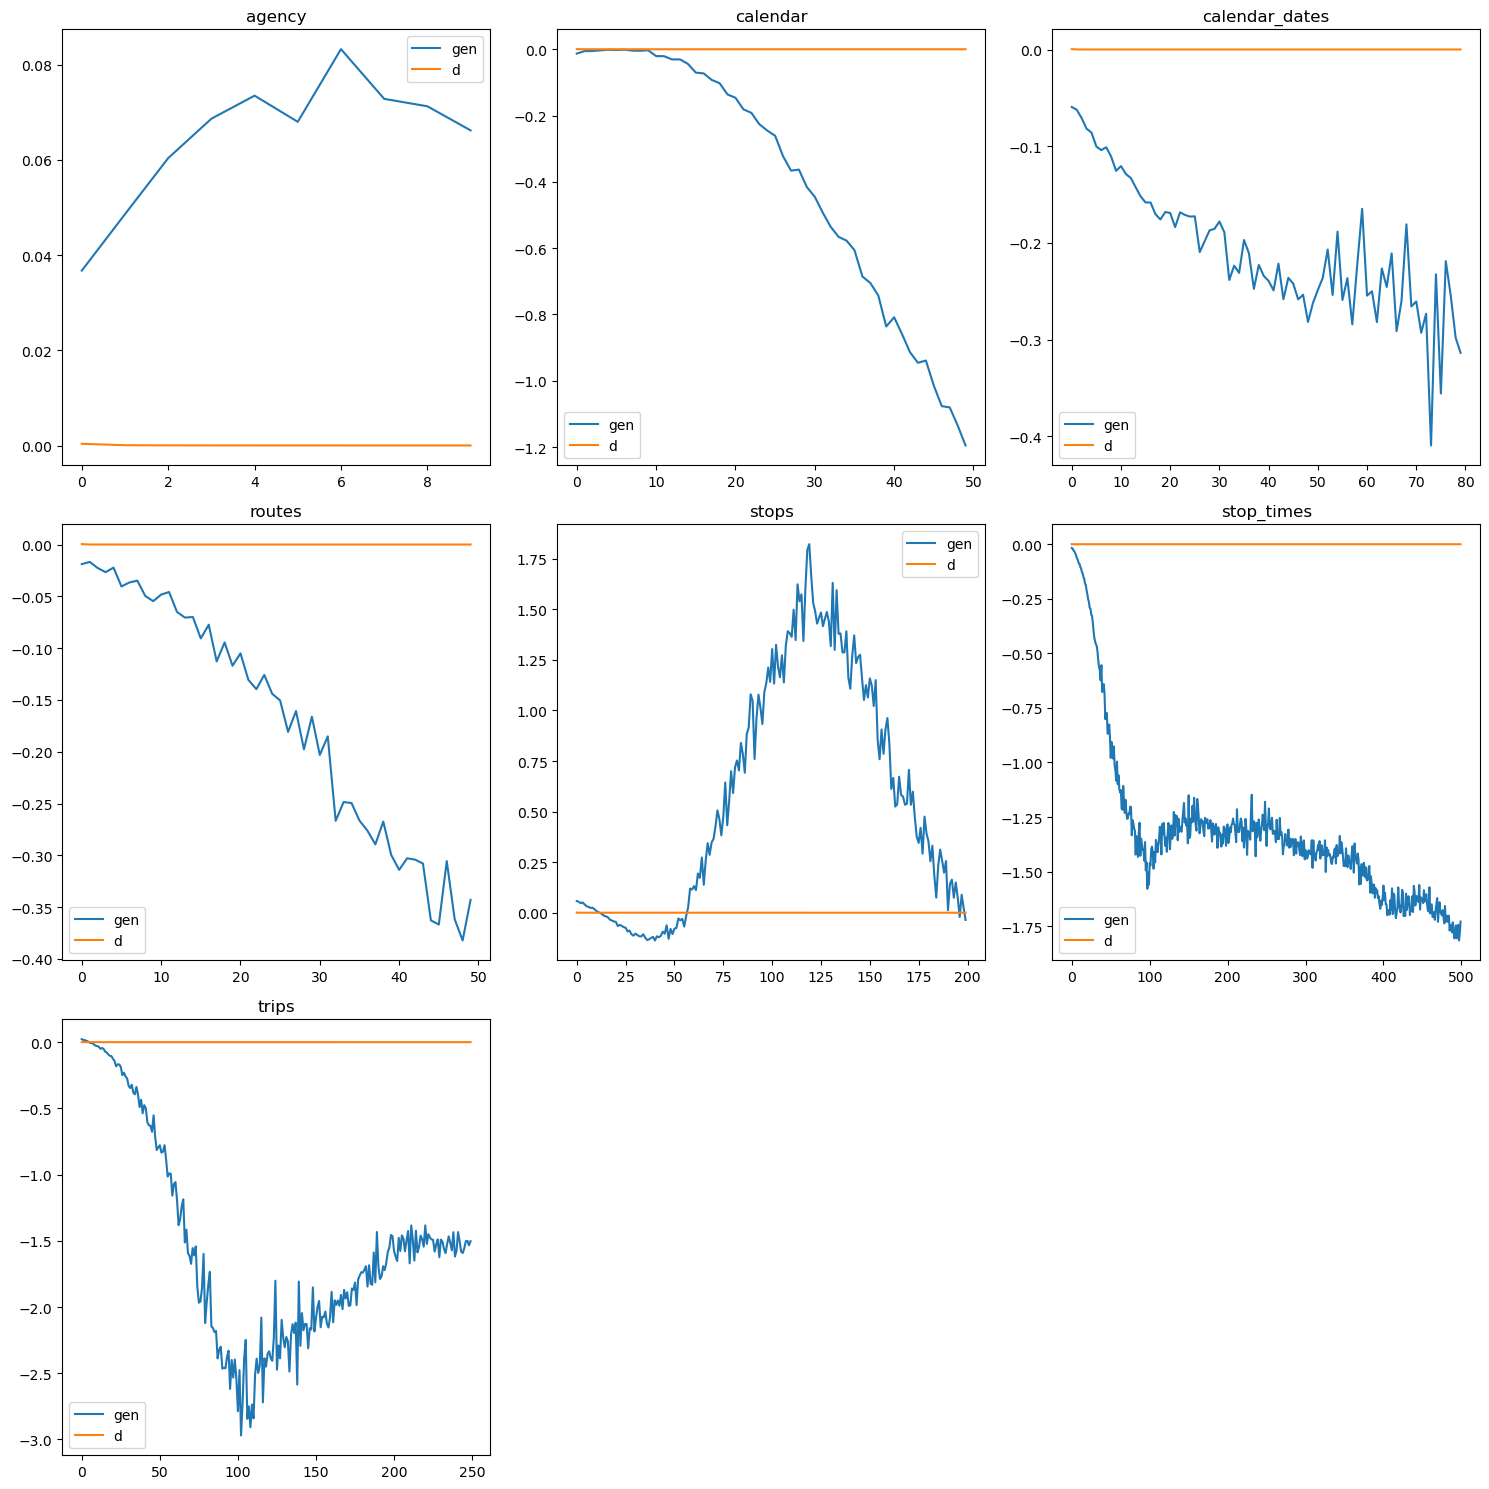

Total Time Used: 6m 28s
CPU times: total: 7min 50s
Wall time: 6min 28s


In [51]:
%%time

collection_training(processed_data_collection, metadata, training_parameter_dict)

# Synthetic Data Generation

In [52]:
def generate_new_array(cdf, unique_elements, num_unique_elements=None, size=20):
    if num_unique_elements is None:
        new_unique_elements = unique_elements
    else:
        new_unique_elements = np.arange(num_unique_elements)
    cdf_values = cdf(new_unique_elements)
    cdf_values = np.insert(cdf_values, 0, 0)
    prob_distribution = np.diff(cdf_values)
    prob_distribution /= prob_distribution.sum()
    new_array = np.random.choice(new_unique_elements, size=size, p=prob_distribution)
    return new_array

In [53]:
def generate_synth_data_collection(metadata, generation_dict, backtransformation_dict, latent_dim=100, seed=123):
    np.random.seed(seed)
    synthetic_data_collection = {}
    features_to_ignore_rounding = ['shape_pt_lat',
                      'shape_pt_lon',
                      'stop_lat',
                      'stop_lon',
                     'shape_dist_traveled']
    
    for df_name, content in metadata.items():
        generator = models.load_model('models/'+df_name+'_gen.h5')
        primary_key = content['primary_key']
        child = content['child']
        parent = content['parent']
        fake_labels_df_dict = {}
        
        if primary_key != []:
            primary_key_col = primary_key[0]
            n_primary_keys = generation_dict[df_name]['nrows']
            fake_labels_df_dict[primary_key_col] = np.arange(n_primary_keys).tolist()
            
        if parent != {}:
            for parent_df_name, fr_key in parent.items():
                n_keys = generation_dict[parent_df_name]['nrows']
                nrows = generation_dict[df_name]['nrows']
                cdf = content['key_distribution'][fr_key]['cdf']
                unique_elements = content['key_distribution'][fr_key]['unique_elements']
                fake_labels_df_dict[fr_key] = generate_new_array(cdf, unique_elements, n_keys, nrows)
        
        if content['is_sequential'] == True:
            for additional_key in content['additional_key']:
                nrows = generation_dict[df_name]['nrows']
                cdf = content['key_distribution'][additional_key]['cdf']
                unique_elements = content['key_distribution'][additional_key]['unique_elements']
                fake_labels_df_dict[additional_key] = generate_new_array(cdf, unique_elements, size=nrows)
        
        fake_labels_df = pd.DataFrame(fake_labels_df_dict).reindex(columns=backtransformation_dict[df_name]['labels_col_names'])
        
        if content['is_sequential'] == True:
            fake_labels_df = fake_labels_df.sort_values(by=content['sort_order'])
            
        scaled_fake_labels_df = pd.DataFrame(backtransformation_dict[df_name]['labels_scaler'].transform(fake_labels_df), columns=backtransformation_dict[df_name]['labels_col_names'])
        latent_dim = 100
        noise = np.random.uniform(-1, 1, size=(generation_dict[df_name]['nrows'], latent_dim))
        raw_fake_table = generator.predict([noise, scaled_fake_labels_df])
        scaled_fake_table = backtransformation_dict[df_name]['table_scaler'].inverse_transform(raw_fake_table)
        fake_table_df = pd.DataFrame(scaled_fake_table, columns=backtransformation_dict[df_name]['table_col_names'])
        fake_data = pd.concat([fake_labels_df, fake_table_df], axis=1)
        fake_data = fake_data.reindex(columns=backtransformation_dict[df_name]['col_names'])
        
        columns_to_int = [col for col in fake_data.columns if col not in features_to_ignore_rounding]
        for col in columns_to_int:
            fake_data[col] = fake_data[col].round().astype(int)
                
        synthetic_data_collection[df_name] = fake_data
        
    return synthetic_data_collection

In [54]:
generation_dict = {k:{'nrows':len(v['table']), 'is_sequential':False} for k,v in processed_data_collection.items()}
generation_dict['calendar_dates']['is_sequential'] = True
generation_dict['stop_times']['is_sequential'] = True
generation_dict['calendar_dates']['sort_by'] = ['service_id','date']
generation_dict['stop_times']['sort_by'] = ['trip_id','stop_sequence']

In [55]:
generation_dict

{'agency': {'nrows': 15, 'is_sequential': False},
 'calendar': {'nrows': 121, 'is_sequential': False},
 'calendar_dates': {'nrows': 674,
  'is_sequential': True,
  'sort_by': ['service_id', 'date']},
 'routes': {'nrows': 215, 'is_sequential': False},
 'stops': {'nrows': 6714, 'is_sequential': False},
 'stop_times': {'nrows': 966790,
  'is_sequential': True,
  'sort_by': ['trip_id', 'stop_sequence']},
 'trips': {'nrows': 32403, 'is_sequential': False}}

In [56]:
%%time

synthetic_data_collection = generate_synth_data_collection(metadata, generation_dict, backtransformation_dict)

CPU times: total: 1min 23s
Wall time: 1min 5s


In [57]:
# del processed_data_collection

In [58]:
with open('pkl/real_data_collection.pkl', 'wb') as f:
    pickle.dump(real_data_collection, f)

In [59]:
with open('pkl/synthetic_data_collection_e500.pkl', 'wb') as f:
    pickle.dump(synthetic_data_collection, f)

In [60]:
# with open('pkl/synthetic_data_collection_e100.pkl', 'wb') as f:
#     pickle.dump(synthetic_data_collection, f)

In [61]:
with open('pkl/sdv_metadata.pkl', 'wb') as f:
    pickle.dump(sdv_metadata, f)